# Basic Usage

In [1]:
# This path append is just for testing from within the examples folder, no need for the user to add this
import sys
sys.path.append("/home/hweiner/Internship/RAMS-MAT/")

import CoMET

%load_ext autoreload

=====Welcome To CoMET=====

This project was supported by the U.S. Department of Energy (DOE) Early Career Research Program, Atmospheric System Research (ASR) program, and the Office of Workforce Development for Teachers and Scientists (WDTS) under the Science Undergraduate Laboratory Internships Program (SULI).

If you are using this software for a publication, please cite: ####




In [16]:
# This cell is uncessary. It just illustrates the CONFIG loading
%autoreload 2
CONFIG = CoMET.CoMET_load(path_to_config="../examples/example_configs/boilerplate.yml")
print(CONFIG['rams']['tobac']['analysis'])
print(CONFIG['rams']['feature_tracking_var'])
print('moaap' in CONFIG)

=====RAMS Setup Found in CONFIG=====
{'eth': {'variable': 'DBZ', 'cell_footprint_height': 2000, 'threshold': 30}, 'max_height': {'variable': 'DBZ', 'cell_footprint_height': 2000, 'threshold': 30}, 'area-low': {'height': 200}, 'area-high': {'height': 2000}}
dbz
False


In [3]:
# This is the only function required to run CoMET. All details are in the CONFIG
import CoMET
%autoreload 2

output = CoMET.CoMET_start(path_to_config="../examples/example_configs/boilerplate_test.yml")

# for i in ['tracking_xarray', 'segmentation_xarray']:
#     output['rams']['tobac']['analysis_object'].return_analysis_dictionary()[i].to_netcdf(f'/share/D3/data/hweiner/RAMS/ToyAnalysisObject/CLN_{i}.h5')
# for j in output['rams']['tobac']['analysis_object'].return_analysis_dictionary().keys()[2:]:
#     import numpy as np
#     np.savetxt(f'/share/D3/data/hweiner/RAMS/ToyAnalysisObject/CLN_{j}.txt')

=====RAMS Setup Found in CONFIG=====
=====Loading RAMS Data=====


=====Loading RAMS Header File Data=====: 100%|██████████| 2/2 [00:00<00:00, 127.65it/s]0:04<00:00,  1.47it/s] 
=====Destaggering Winds and Adding Coordinates/Attributes=====: 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]
=====Calculating RAMS Reflectivity=====: 100%|██████████| 6/6 [01:47<00:00, 17.87s/it]


=====Starting RAMS tobac Feature ID=====
=====Starting RAMS tobac Feature Linking=====
=====Starting RAMS tobac 2D Segmentation=====
=====Starting RAMS tobac 3D Segmentation=====


=====Performing tobac Segmentation to UDAF=====: 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


=====Starting RAMS tobac Analysis Calculations=====


=====Calculating Echo Top Heights=====: 100%|██████████| 2/2 [01:02<00:00, 31.15s/it]


=====Converting RAMS tobac Output to CoMET-UDAF=====
=====RAMS tobac Tracking Complete=====
=====CoMET Performance Diagonistics=====
$ Total Process Time: 234.52 Seconds
$ Allocated Resources: Cores = 32


## ETH Codes

In [94]:
def calculate_ETH(
    analysis_object,
    threshold,
    variable=None,
    cell_footprint_height=2000,
    quantile=0.95,
    **args,
):
    """
    Inputs:
        analysis_object: A CoMET-UDAF standard analysis object containing at least UDAF_tracks and UDAF_segmentation_2d or UDAF_segmentation_3d, and segmentation_xarray
        threshold: The value which needs to be exceeded to count towards the echo top height. I.e. 15 for reflectivity.
        variable: The variable from the input segmentation_xarray which should be used for calculating ETH
        cell_footprint_height: The height used to calculate the cell area to determine where to calculate ETHs
        quantile: The percentile of calculated ETHs to return
    Outputs:
        eth_info: A pandas dataframe with the following rows: frame, feature_id, cell_id, eth where eth is in km
    """

    import numpy as np
    import xarray as xr
    import pandas as pd
    from tqdm import tqdm

    # If input variable field is 2D return None. Also, if DataArray, use those values for calculations. If Dataset, use tracking_var to get variable
    if type(analysis_object["segmentation_xarray"]) == xr.core.dataarray.DataArray:

        if len(analysis_object["segmentation_xarray"].shape) != 4:
            return None

        else:
            variable_field = analysis_object["segmentation_xarray"]

    else:

        if len(analysis_object["segmentation_xarray"][variable].shape) != 4:
            return None

        else:
            variable_field = analysis_object["segmentation_xarray"][variable]

    # If 3D segmentation is available, use that to calculate cell footprint, otherwise use 2D segmentation
    if analysis_object["UDAF_segmentation_3d"] is not None:

        height_index = find_nearest(
            analysis_object["UDAF_segmentation_3d"].altitude.values,
            cell_footprint_height,
        )

        footprint_data = analysis_object["UDAF_segmentation_3d"].Feature_Segmentation[
            :, height_index
        ]

    elif analysis_object["UDAF_segmentation_2d"] is not None:

        footprint_data = analysis_object["UDAF_segmentation_2d"].Feature_Segmentation

    else:
        raise Exception("!=====Missing Segmentation Input=====!")

    eth_info = {"frame": [], "feature_id": [], "cell_id": [], "eth": []}  # in km

    frame_groups = analysis_object["UDAF_linking"].groupby("frame")

    # Loop over frames
    for ii, frame in tqdm(
        enumerate(frame_groups),
        desc="=====Calculating Echo Top Heights=====",
        total=frame_groups.ngroups,
    ):

        # Loop over each feature
        for feature in frame[1].groupby("feature_id"):

            # Get the indices of the cell footprint
            proper_indices = np.argwhere(footprint_data[frame[0]].values == feature[0]) 
            # try to see if you can get the altitude information from footprint data

            # Cells which have no segmented output should get a NaN
            if len(proper_indices) == 0:
                eth_info["frame"].append(frame[0])
                eth_info["feature_id"].append(feature[0])
                eth_info["cell_id"].append(feature[1]["cell_id"].min())
                eth_info["eth"].append(np.nan)
                continue

            eth_set = []

            # Calculate ETH for each location
            for iy, ix in proper_indices:

                max_alt_index = np.argwhere(
                    variable_field[frame[0], :, iy, ix].values > threshold
                )

                # If there are no indices greater than threshold, skip
                if len(max_alt_index) != 0:
                    max_alt_index = max_alt_index.max()
                else:
                    eth_set.append(np.nan)
                    continue

                max_alt = variable_field.altitude.values[max_alt_index]
                eth_set.append(max_alt)

            eth_info["frame"].append(frame[0])
            eth_info["feature_id"].append(feature[0])
            eth_info["cell_id"].append(feature[1]["cell_id"].min())

            # If all NaN slice, append just np.nan
            if np.isnan(eth_set).all():
                eth_info["eth"].append(np.nan)
            else:
                eth_info["eth"].append(np.nanquantile(eth_set, quantile) / 1000)

    return pd.DataFrame(eth_info)

In [113]:
def HopefullyFasterThanTravis(analysis_object, threshold, variable=None,cell_footprint_height = 2000, quantile=0.95):
    import numpy as np
    import pandas as pd

    def find_nearest(array, pivot):
        import numpy as np

        array = np.asarray(array)
        idx = (np.abs(array - pivot)).argmin()
        return idx

    seg3d = analysis_object['UDAF_segmentation_3d'].Feature_Segmentation

    variable_field = analysis_object["segmentation_xarray"][variable]

    altitudes = variable_field.altitude.values
    height_index = find_nearest(altitudes, cell_footprint_height)

    frame_groups = analysis_object["UDAF_linking"].groupby("frame")

    eth_info = {'frame' : [], 'feature_id' : [], 'cell_id' : [], 'eth' : []}
    for frame in frame_groups:
        for feature in frame[1].groupby("feature_id"):

            var_above_thresh_in_frame = variable_field[frame[0], :, :, :].values > threshold
            seg_above_thresh_3d = seg3d[frame[0], height_index, :, :].values

            seg_above_thresh = np.where(var_above_thresh_in_frame[height_index], 
                                        seg_above_thresh_3d[height_index], 
                                        -1) # make sure the threshold is met

            foot_print_feature_coords = np.argwhere(seg_above_thresh == feature[0])
            inds_on_footprint = [(x,y) for y, x  in foot_print_feature_coords]


            seg_above_thresh_3d = np.where(var_above_thresh_in_frame, 
                                            seg_above_thresh_3d,
                                            -1) # make sure the threshold is met

            prop_inds_3d = np.argwhere(seg_above_thresh_3d == feature[0])
            sortedinds_3d = prop_inds_3d.T
            argsorter = np.flip(np.argsort(sortedinds_3d[0]))
            sortedinds_3d[0] = sortedinds_3d[0][argsorter]
            sortedinds_3d[1] = sortedinds_3d[1][argsorter]
            sortedinds_3d[2] = sortedinds_3d[2][argsorter]
            sortedinds_3d = sortedinds_3d.T

            # checked_xy = []
            counter = 0
            end = False
            for z, y, x in sortedinds_3d:
                if (x, y) in inds_on_footprint and var_above_thresh_in_frame[z, y, x]:# and (x, y) not in checked_xy:
                    # checked_xy.append((x,y))
                    eth_info["frame"].append(frame[0])
                    eth_info["feature_id"].append(feature[0])
                    eth_info["cell_id"].append(feature[1]["cell_id"].min())
                    eth_info["eth"].append(altitudes[z])
                    break
                    # checked_xy.append((x, y))

            eth_info["frame"].append(frame[0])
            eth_info["feature_id"].append(feature[0])
            eth_info["cell_id"].append(feature[1]["cell_id"].min())
            eth_info["eth"].append(np.nan)
    return pd.DataFrame(eth_info)

## End of ETH Codes

In [114]:
analysis_object = output['rams']['tobac']['analysis_object'].return_analysis_dictionary()
threshold = 30
cell_footprint_height = 2000
variable='DBZ'
import time
mystart = time.time()
mydata = HopefullyFasterThanTravis(analysis_object, threshold, variable,cell_footprint_height, quantile=0.95)
myend = time.time()

hisstart = time.time()
hisdata = calculate_ETH(analysis_object, threshold, variable, cell_footprint_height, quantile=0.95)
hisend = time.time()

print(f'the winner is decided')
print(f'my time is {myend - mystart}')
print(f'his time is {hisend - hisstart}')

=====Calculating Echo Top Heights=====: 100%|██████████| 2/2 [01:23<00:00, 41.93s/it]

the winner is decided
my time is 88.34828090667725
his time is 83.87970232963562


In [99]:
print(output['rams']['tobac']['analysis']['eth'])
# print(output['rams']['tobac']['analysis']['eth'])

     frame  feature_id  cell_id        eth
0        0           0        0   2.555668
1        0           1        1   3.594756
2        0           2        2        NaN
3        0           3        3   2.920123
4        0           4        4   2.225097
..     ...         ...      ...        ...
209      1         209       96  10.481391
210      1         210       97   8.981391
211      1         211       99  10.781391
212      1         212      101   9.881391
213      1         213      122        NaN

[214 rows x 4 columns]


In [4]:
# print(output['rams']['tobac'].keys())
print(output['rams']['tobac']['analysis'].keys())
print(output["rams"]["tobac"]["analysis_object"])

dict_keys(['eth', 'area-low', 'area-high'])


In [54]:
print(output['rams']['tobac']['analysis']['eth'].keys())
output['rams']['tobac']['analysis']['eth']['cell_id']

Index(['frame', 'feature_id', 'cell_id', 'eth'], dtype='object')


0         0
1         1
2         2
3         3
4         4
       ... 
3622    461
3623    442
3624    436
3625    463
3626    240
Name: cell_id, Length: 3627, dtype: int64

## Plotting Histograms

<class 'pandas.core.series.Series'>
2     NaN
104   NaN
216   NaN
Name: eth, dtype: float64
5     NaN
108   NaN
Name: eth, dtype: float64
6   NaN
Name: eth, dtype: float64
7     NaN
110   NaN
Name: eth, dtype: float64
14    NaN
122   NaN
234   NaN
341   NaN
Name: eth, dtype: float64
15    NaN
123   NaN
Name: eth, dtype: float64
17    NaN
125   NaN
241   NaN
348   NaN
441   NaN
538   NaN
642   NaN
Name: eth, dtype: float64
18    NaN
127   NaN
239   NaN
350   NaN
443   NaN
541   NaN
Name: eth, dtype: float64
19    NaN
128   NaN
Name: eth, dtype: float64
20    NaN
132   NaN
244   NaN
352   NaN
Name: eth, dtype: float64
21    NaN
129   NaN
242   NaN
349   NaN
442   NaN
539   NaN
641   NaN
741   NaN
836   NaN
Name: eth, dtype: float64
22     NaN
126    NaN
238    NaN
345    NaN
437    NaN
536    NaN
638    NaN
738    NaN
891    NaN
989    NaN
1083   NaN
1181   NaN
1282   NaN
1384   NaN
1483   NaN
1585   NaN
1680   NaN
1768   NaN
1858   NaN
1953   NaN
2048   NaN
2083   NaN
2172   NaN
2262   

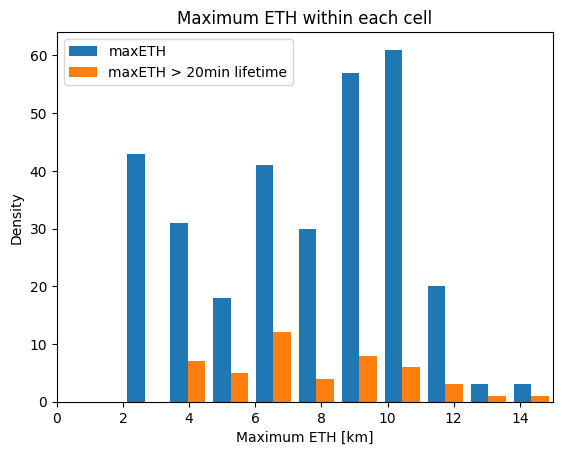

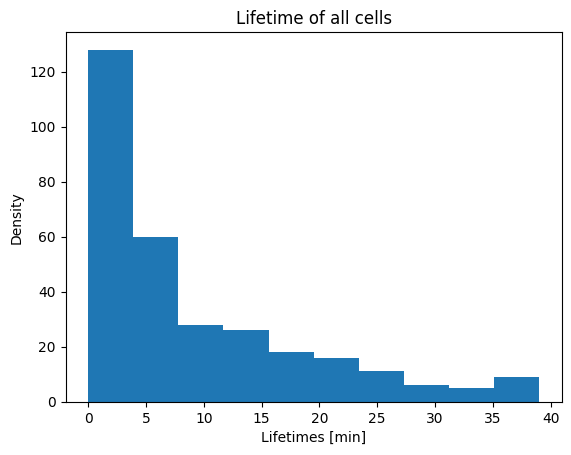

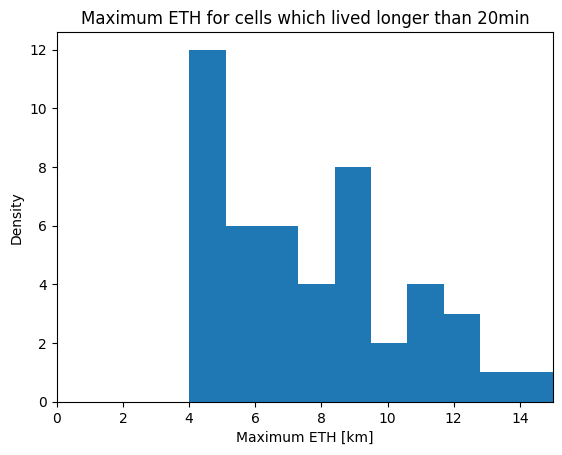

In [53]:
# output['rams']['tobac']['analysis']['eth']['eth'][output['rams']['tobac']['analysis']['eth']['cell_id'] == 10]
# print(output['rams']['tobac']['UDAF_linking'].keys())
# output['rams']['tobac']['UDAF_linking']['lifetime'][output['rams']['tobac']['UDAF_linking']['cell_id'] == 10]
# find the max eth for each cell id
import numpy as np
import matplotlib.pyplot as plt

cellids = np.unique(output['rams']['tobac']['UDAF_linking']['cell_id'])
maxETH = np.zeros_like(cellids)
lifetimes = np.zeros_like(cellids)
ETH_morethan_20min = np.zeros_like(cellids)

s = output['rams']['tobac']['analysis']['eth']['eth']
print(type(s))

badInds = []
for id in cellids:
    cellbool = output['rams']['tobac']['UDAF_linking']['cell_id'] == id
    out = s[cellbool].values
    if sum(np.isnan(out)) == len(out):
        badInds.append(id)
    else:
        maxETH[id] = np.nanmax(s[cellbool].dropna())
        lasttime = output['rams']['tobac']['UDAF_linking']['lifetime'][output['rams']['tobac']['UDAF_linking']['cell_id'] == id].iloc[-1]
        firsttime = output['rams']['tobac']['UDAF_linking']['lifetime'][output['rams']['tobac']['UDAF_linking']['cell_id'] == id].iloc[0]
        lifetimes[id] = float((lasttime - firsttime).total_seconds())
        if (lifetimes[id] / 60) < 20:
            ETH_morethan_20min[id] = 99999
        else:
            ETH_morethan_20min[id] = maxETH[id]
for b in badInds:
    print(s[output['rams']['tobac']['UDAF_linking']['cell_id'] == b])
maxETH = np.delete(maxETH, badInds)
lifetimes = np.delete(lifetimes, badInds)
ETH_morethan_20min = np.delete(ETH_morethan_20min, badInds)

ETH_morethan_20min = np.where(ETH_morethan_20min == 99999, np.NaN, ETH_morethan_20min)

plt.hist([maxETH, ETH_morethan_20min], label=['maxETH', 'maxETH > 20min lifetime'])
plt.title('Maximum ETH within each cell')
plt.xlabel('Maximum ETH [km]')
plt.ylabel('Density')
plt.xlim(0, 15)
plt.legend()
plt.show()

# plot histogram of lifetimes
plt.hist(lifetimes / 60)
plt.title('Lifetime of all cells')
plt.xlabel('Lifetimes [min]')
plt.ylabel('Density')
plt.show()

ETH_morethan_20min = np.where(ETH_morethan_20min == 99999, np.NaN, ETH_morethan_20min)
plt.hist(ETH_morethan_20min)
plt.title('Maximum ETH for cells which lived longer than 20min')
plt.xlabel('Maximum ETH [km]')
plt.ylabel('Density')
plt.xlim(0, 15)
plt.show()

In [61]:
al = output['rams']['tobac']['analysis']['area-low'].area.values
al = al[~np.isnan(al)]
print(np.histogram(al))

(array([1408,  509,  192,  100,   82,   19,    4,    5,    9,    3]), array([2.50000e-01, 3.11250e+01, 6.20000e+01, 9.28750e+01, 1.23750e+02,
       1.54625e+02, 1.85500e+02, 2.16375e+02, 2.47250e+02, 2.78125e+02,
       3.09000e+02]))


In [68]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(3)

anal = output['rams']['tobac']['analysis']
for frame in anal['area-low'].frame[:10]:
    al = anal['area-low'].area.values
    al = al[~np.isnan(al)]
    heights, bins = np.histogram(al, bins = 10)
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'magenta', 'brown', 'lavender']
    for ind, h, b in zip(np.arange(len(heights)), heights, bins):
        ax[0].scatter(np.ones_like(heights) * frame, heights, label = f'Area = {bins}km^2')
    # ax[0].hist([output['rams']['tobac']['analysis']['area-low'].area.values, output['rams']['tobac']['analysis']['area-high'].area.values], label=["RAMS, area-low", "RAMS, area-high"], density = True)
ax[0].set_xlabel("Frame [minutes]")
ax[0].set_ylabel("Density")
ax[0].set_title('Low area cell population')
ax[0].legend()
plt.show()


# plt.hist(output['rams']['tobac']['analysis']['eth']['eth'], density=True)
# plt.xlabel('Echo Top Height [km]')
# plt.ylabel('Density')
# plt.show()

# print(output['rams']['tobac']['UDAF_linking']['lifetime'])
# print(type(output['rams']['tobac']['UDAF_linking']['lifetime']))
# plt.hist(output['rams']['tobac']['UDAF_linking']['lifetime'].values)
# plt.title('Lifetime')
# plt.show()



KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f603467d080> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

## Hidden eth code

[[[[-30.         -30.         -30.         ... -30.
    -30.         -30.        ]
   [-30.         -30.         -30.         ... -30.
    -30.         -30.        ]
   [-30.         -30.         -30.         ... -30.
    -30.         -30.        ]
   ...
   [ -7.75271428  -7.35378757  -7.92187964 ...  42.92015297
     40.77327834  36.90812125]
   [ -5.83740052  -4.6790961   -6.00251228 ...  40.76228006
     38.71216595  35.22511953]
   [-30.         -30.         -30.         ...  33.2891206
     33.26322157  33.53579474]]

  [[-30.         -30.         -30.         ... -30.
    -30.         -30.        ]
   [-30.         -30.         -30.         ... -30.
    -30.         -30.        ]
   [-30.         -30.         -30.         ... -30.
    -30.         -30.        ]
   ...
   [ -7.81626277  -7.45833208  -7.89203325 ...  43.13834566
     41.05928411  37.18350627]
   [ -5.80053485  -4.66526318  -5.94282104 ...  41.0752496
     39.0446182   35.51181537]
   [-30.         -30.         -30

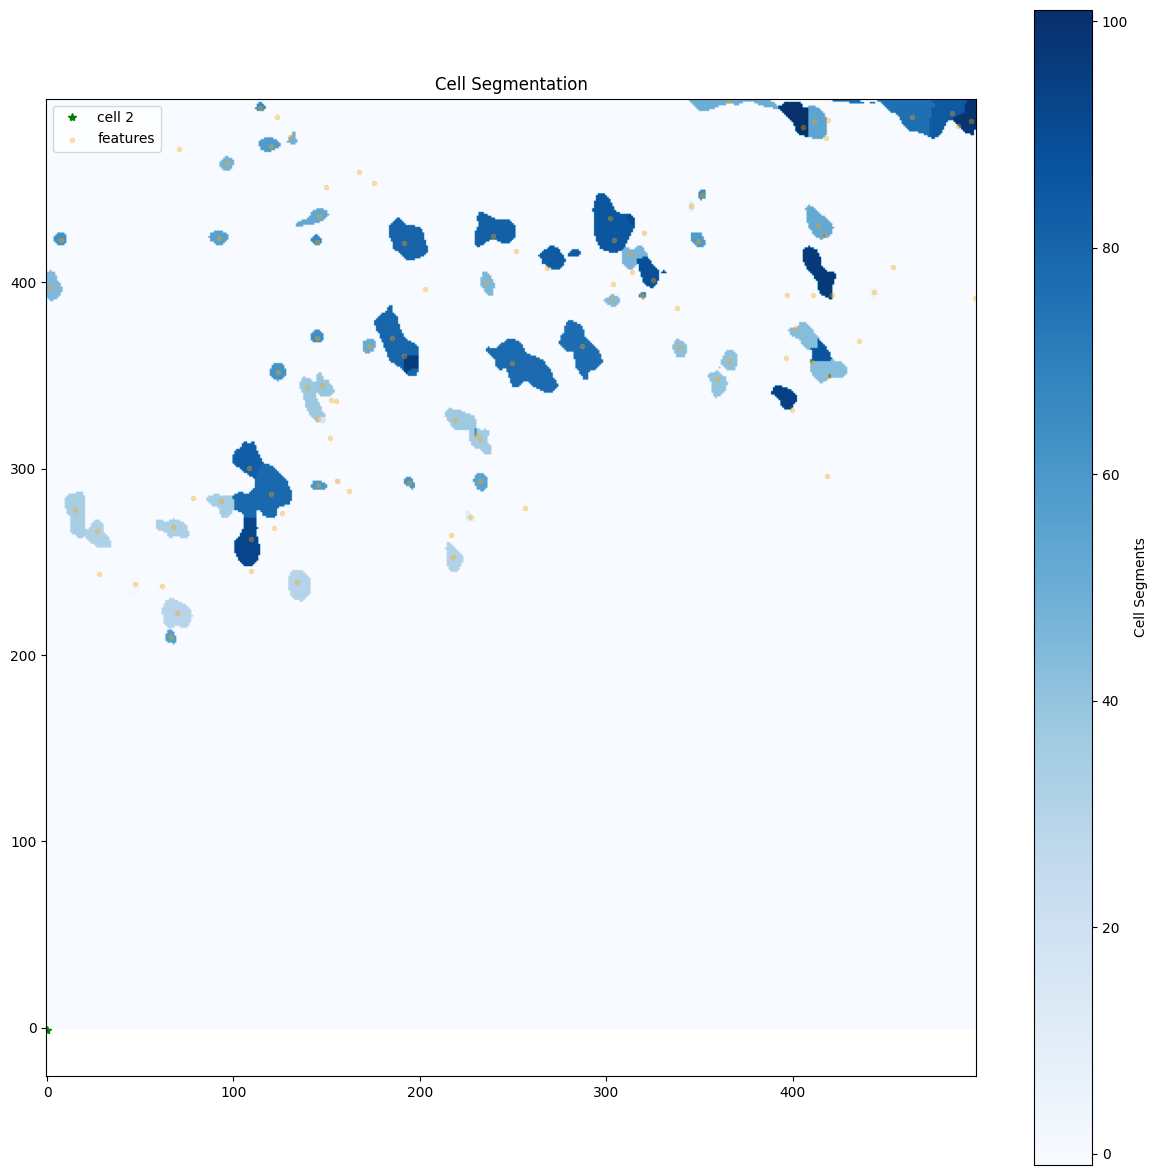

In [8]:
import matplotlib.pyplot as plt
from skimage import measure
import numpy as np

def find_nearest(array, pivot):
    import numpy as np

    array = np.asarray(array)
    idx = (np.abs(array - pivot)).argmin()
    return idx

anal_object = output['rams']['tobac']['analysis_object'].return_analysis_dictionary()
# print(anal_object.keys())

cellid = output['rams']['tobac']['analysis']['eth']['cell_id']
feature_id = output['rams']['tobac']['analysis']['eth']['feature_id']
cell_seg = output['rams']
# print(output['rams']['tobac']['analysis']['eth'].keys())
eth = output['rams']['tobac']['analysis']['eth']

udaf_features = anal_object['UDAF_features']

# there are some cells with only nan values and we want to see why. Maybe we can find the dbz values of one cell
# throughout time at all altitudes, then see if the x, y coordinate is outside of the cross section at our given altitude

trackingarr = anal_object['tracking_xarray']
print(trackingarr['DBZ'].values)
altitudes = trackingarr['altitude']
indx = find_nearest(altitudes, 2000)

# print(trackingarr['DBZ'])

print(anal_object['UDAF_segmentation_3d']['Feature_Segmentation'].shape)
feature_seg = anal_object['UDAF_segmentation_3d']['Feature_Segmentation']
cell_seg = anal_object['UDAF_segmentation_3d']['Cell_Segmentation']
print(np.unique(feature_seg[20, indx, :, :]))
print(np.unique(cell_seg[20, indx, :, :]))
print(len(np.unique(cell_seg[20, indx, :, :])) == len(np.unique(feature_seg[20, indx, :, :])))

# plt.imshow(anal_object['UDAF_segmentation_3d']['Cell_Segmentation'][20, indx, :, :], origin='lower', cmap='Blues')
# cbar0 = plt.colorbar()
# cbar0.set_label('Cell Segments')
# plt.imshow(anal_object['UDAF_segmentation_3d']['Feature_Segmentation'][20, indx, :, :], origin='lower', cmap='Reds', alpha=0.3)
# cbar1 = plt.colorbar()
# cbar1.set_label('Feature Segments')
# plt.title('Overlap')
# plt.show()

# plt.imshow(anal_object['UDAF_segmentation_3d']['Feature_Segmentation'][20, indx, :, :], origin='lower')
# plt.title('Feature Segmentation')
# plt.colorbar()
# plt.show()

# 3d plotting the cells code
# dbz = trackingarr['DBZ']
# x = np.arange(len(dbz[0, 0, 0, :]))
# y = np.arange(len(dbz[0, 0, :, 0]))
# footprintx, footprinty = np.meshgrid(x, y)

# allcells = nonancells
# print(f'the number of cells is {len(allcells)}')
# ncells = 3
# somecells = [0]#[27, 28, 37] #np.random.choice(allcells, ncells)
# print(f'the number of the cells being plotted is {len(somecells)}')

# nframes = 1
# framesToLookAt = np.arange(nframes)
# fig = plt.figure(figsize=[15, 15])

# for find, frame in enumerate(framesToLookAt):
#     for cind, cell in enumerate(somecells):
#         ax = fig.add_subplot(ncells, nframes, 1 + cind + find * ncells, projection='3d')

#         mask = (anal_object['UDAF_segmentation_3d']['Cell_Segmentation'][frame, :, :, :] == cell).values
#         verts, faces, normals, values = measure.marching_cubes(mask, 0.5)

#         ax.plot_trisurf(
#             verts[:, 0], verts[:, 1], faces, verts[:, 2], cmap='Spectral',
#             antialiased=False, linewidth=0.0)
#         ax.plot(xs=footprintx, ys=footprinty, zs=indx, alpha = 0.1, label='footprint')
#         # ax.set_zticks(np.arange(0, 100, 20), [find_nearest(altitudes, b) for b in np.arange(0, 100, 20)])
#         ax.set_zlim(0, 70)
#         # ax.set_xlim(-10, 500)
#         # ax.set_ylim(-10, 500)
#         ax.set_title(f'frame {find}, cell {cell}')
# plt.figure(figsize=[15, 15])
# plt.tight_layout()
# plt.show()


plt.figure(figsize=[15, 15])
plt.imshow(anal_object['UDAF_segmentation_3d']['Cell_Segmentation'][0, indx, :, :], origin='lower', cmap='Blues')
b = np.array(output['rams']['tobac']['analysis']['eth']['feature_id'] == 2, dtype=bool)
ix = find_nearest(anal_object['UDAF_features']['west_east'], anal_object['UDAF_features']['west_east'][b].values[0])
iy = find_nearest(anal_object['UDAF_features']['south_north'], anal_object['UDAF_features']['south_north'][b].values[0])
plt.plot(anal_object['UDAF_segmentation_3d']['Cell_Segmentation'][0, indx, iy, ix], color='green', linestyle='', label='cell 2', marker='*')
print(f'cell 2 is at {ix}, {iy}')
dbz = trackingarr['DBZ'][0, :, iy, ix].values
print(f'the dbz at cell 2 is {dbz}')
cbar0 = plt.colorbar()
cbar0.set_label('Cell Segments')
plt.scatter(udaf_features['west_east'][udaf_features['frame'] == 0], udaf_features['south_north'][udaf_features['frame'] == 0], 
            marker='.', label='features', alpha=0.3, color='orange')
plt.title('Cell Segmentation')
plt.legend()
plt.show()